In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import xarray as xr

from scipy.stats import percentileofscore
from matplotlib.colors import Normalize, to_hex

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Set seed
seed = 8888
rng = np.random.default_rng(seed)

# Get point colours from colourmap
norm = Normalize(vmin=-0.5, vmax=1.5)
cmap1 = plt.get_cmap('Greys')
cmap2 = plt.get_cmap('Reds')

# Map each scalar to a color
blacks = [to_hex(cmap1(norm(value))) for value in [0,1]]
reds = [to_hex(cmap2(norm(value))) for value in [0,1]]

# 1. State a clear question
- What is the causal effect of sex on weight?
- What is the direct causal effect of sex on weight?

### Load data
The dataframe consists of the heights, weights, sex and age of individuals in a certain population.

In [3]:
df = pd.read_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Code/Python/pymc/pymc-resources/Rethinking_2/Data/Howell1.csv', sep=';')
df = df[df['age'] >= 18]
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


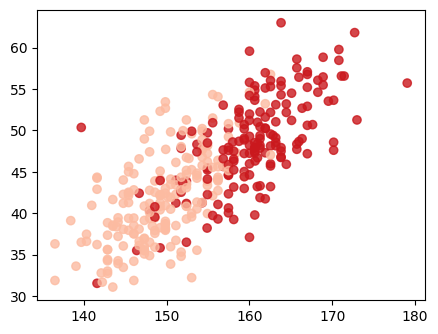

In [4]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(df['height'], df['weight'], c=df['male'], cmap='Reds', alpha=0.8, vmin=-0.5, vmax=1.5)
ax.set_aspect('equal')

plt.show()

# 2. Sketch out the causal assumptions (DAG) of the model
In this case, I have sketched out the DAG on my notebook.

# 3. Define a generative model
### Generate data
Here, we generate synthetic data based on causal assumptions of our system and visualise these data.

In [5]:
def sim_HW(S, a, b):
    N = len(S)
    H = np.where(S == 0, 150, 160) + rng.normal(0, 5, size=N)
    W = a[S] + b[S] * H + rng.normal(0, 5, size=N)
    
    sim_data = pd.DataFrame({'male': S, 'height': H, 'weight': W})
    
    return sim_data

Since we have two questions to address with these data, we'll focus on them sequentially. First, we'll focus on the

#### Total causal effect of sex on weight

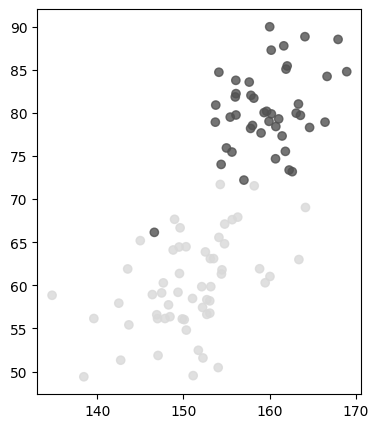

In [6]:
S = np.random.randint(0, 2, size=100)
a = np.array([0, 0])
b = np.array([0.4, 0.5])
sim_data = sim_HW(S, a, b)

fig,ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(sim_data['height'], sim_data['weight'], c=sim_data['male'], cmap='Greys', alpha=0.8, vmin=-0.5, vmax=1.5)
ax.set_aspect('equal')

plt.show()

### Prior predictive distribution
Before we start running our statistical model, we do a prior predictive check. This is to make sure that our priors aren't totally crazy.

In [75]:
a = rng.normal(60, 10, size=(100,2))
b = xr.DataArray(rng.uniform(0, 1, size=(100,2)), dims=['b0','b1'])

x = xr.DataArray(np.linspace(135,185), dims='x')
y = a.reshape(100,2,1) + b*x

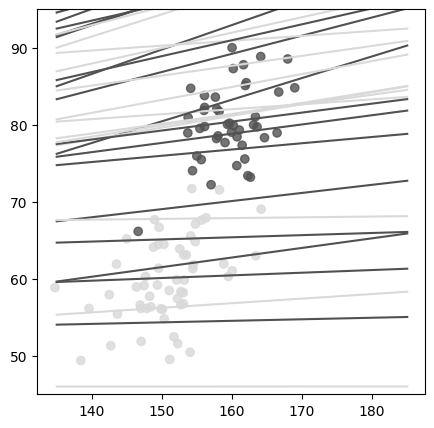

In [8]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(sim_data['height'], sim_data['weight'], c=sim_data['male'], cmap='Greys', alpha=0.8, vmin=-0.5, vmax=1.5)
for i in range(50):
    ax.plot(x, y[i][0], color=blacks[0])
    ax.plot(x, y[i][1], color=blacks[1])

ax.set_ylim(45,95)

plt.show()

# 4. Design a statistical way to build the estimator using the generative model
### Fit model to generated data
Here, we fit a linear regression to the generated data.

In [9]:
with pm.Model() as model:
    # Define priors
    alpha = pm.Normal('alpha', mu=[60, 60], sigma=[10, 10], shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # Define likelihood
    weight_obs = pm.Normal('weight_obs', mu=alpha[sim_data['male'].values], sigma=sigma, observed=sim_data['weight'].values)
    
    # Inference
    idata = pm.sample(1000)
    
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],59.976,0.724,58.602,61.296,0.009,0.007,5903.0,2954.0,1.0
alpha[1],80.071,0.789,78.520,81.547,0.010,0.007,6117.0,2980.0,1.0
sigma,5.246,0.383,4.556,5.978,0.006,0.004,4962.0,2766.0,1.0


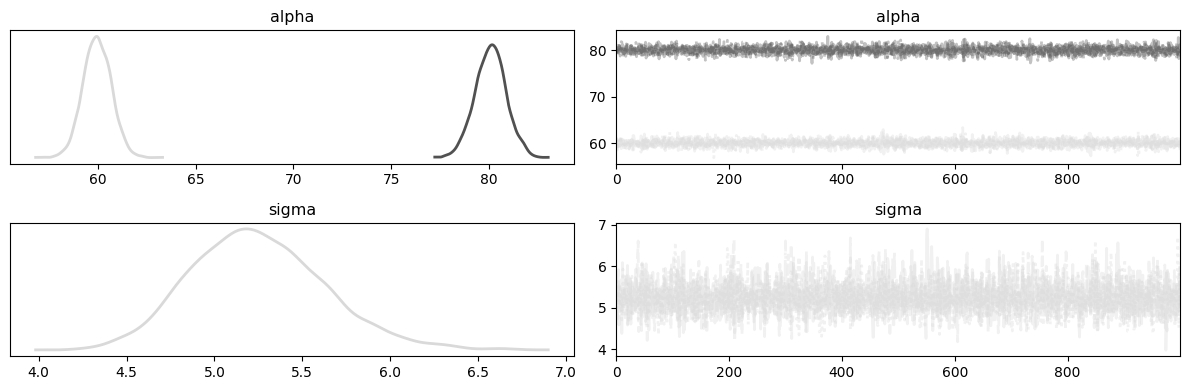

In [10]:
az.plot_trace(idata, compact=True, combined=True, compact_prop={'color': blacks, 'linewidth': [2,2]})
plt.tight_layout()
plt.show()

Now that we have the posterior distributions of our parameters, we can use them to simulate model fits to our generated data.

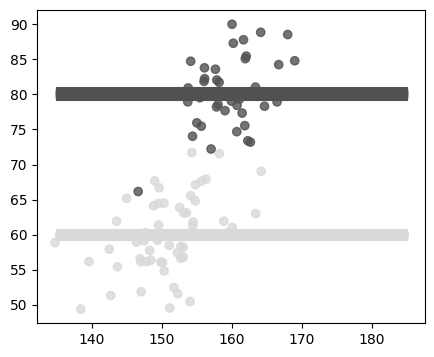

In [11]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(sim_data['height'], sim_data['weight'], c=sim_data['male'], cmap='Greys', alpha=0.8, vmin=-0.5, vmax=1.5)
for i in range(50):
    ax.plot(x, np.repeat(idata.posterior['alpha'].mean(axis=0)[i,0].values, len(x)), color=blacks[0])
    ax.plot(x, np.repeat(idata.posterior['alpha'].mean(axis=0)[i,1].values, len(x)), color=blacks[1])
ax.set_aspect('equal')

plt.show()

# 5. Analyse real data
Now that we know our model works with the synthetic data, we'll feed the real data from above.

In [12]:
df_sampled = df.sample(n=len(df))

In [13]:
with pm.Model() as model:
    # Define priors
    alpha = pm.Normal('alpha', mu=[60, 60], sigma=[10, 10], shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # Define likelihood
    weight_obs = pm.Normal('weight_obs', mu=alpha[df_sampled['male'].values], sigma=sigma, observed=df_sampled['weight'].values)
    
    # Inference
    idata = pm.sample(1000)
    
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],41.841,0.418,41.082,42.646,0.005,0.004,5789.0,3163.0,1.0
alpha[1],48.615,0.429,47.799,49.407,0.006,0.004,5686.0,3237.0,1.0
sigma,5.530,0.212,5.150,5.951,0.003,0.002,5386.0,2909.0,1.0


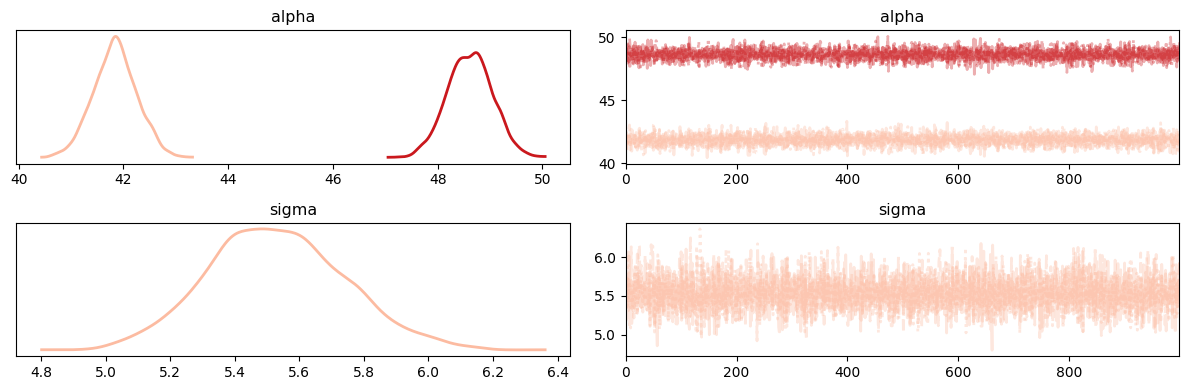

In [14]:
az.plot_trace(idata, compact=True, combined=True, compact_prop={'color': reds, 'linewidth': [2,2]})
plt.tight_layout()
plt.show()

The trace plot above shows us the posterior distributions of `alpha`. This represents the mean of the male and female weights in the data. Next, we would like to plot the distribution of male and female weights. These distributions of course will be much wider than the ones above and can be plotted using the alpha and sigma values in the posterior distributions.

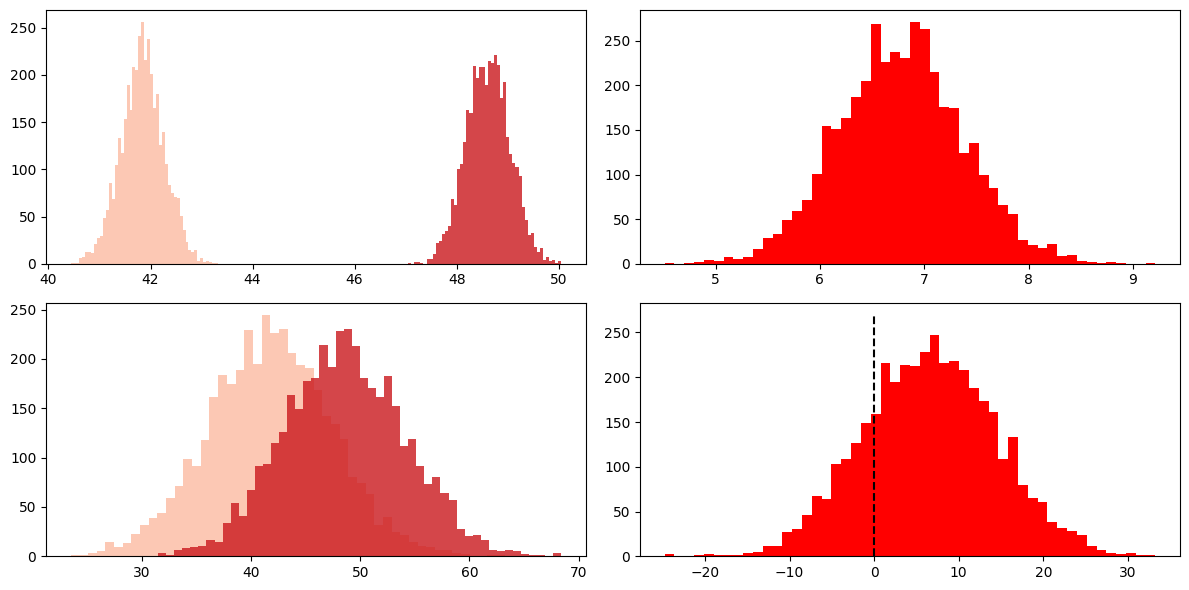

In [15]:
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(idata.posterior['alpha'][...,0].values.reshape(-1,), color=reds[0], bins=50, alpha=0.8)
ax1.hist(idata.posterior['alpha'][...,1].values.reshape(-1,), color=reds[1], bins=50, alpha=0.8)

ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(rng.normal(idata.posterior['alpha'][...,0].values, idata.posterior['sigma'].values).reshape(-1,), color=reds[0], bins=50, alpha=0.8)
ax2.hist(rng.normal(idata.posterior['alpha'][...,1].values, idata.posterior['sigma'].values).reshape(-1,), color=reds[1], bins=50, alpha=0.8)

ax3 = fig.add_subplot(gs[0, 1])  # Use 'gs[:, 1]' to span both rows in the second column
ax3.hist((idata.posterior['alpha'][...,1].values.reshape(-1,) - idata.posterior['alpha'][...,0].values.reshape(-1,)), color='red', bins=50)

ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(rng.normal(idata.posterior['alpha'][...,1].values, idata.posterior['sigma'].values).reshape(-1,) - rng.normal(idata.posterior['alpha'][...,0].values, idata.posterior['sigma'].values).reshape(-1,), color='red', bins=50)
ax4.vlines(0, ymin=0, ymax=270, color='black', linestyles='dashed')

plt.tight_layout()
plt.show()


In [16]:
percentileofscore(rng.normal(idata.posterior['alpha'][...,1].values, idata.posterior['sigma'].values).reshape(-1,) - rng.normal(idata.posterior['alpha'][...,0].values, idata.posterior['sigma'].values).reshape(-1,), 0., kind='rank')

20.275000000000002

This tells us that if we draw two individuals from this population at random (one man and one woman), in `~19%` of the cases the woman will be heavier than the man.

And the model fit to our data looks like this.

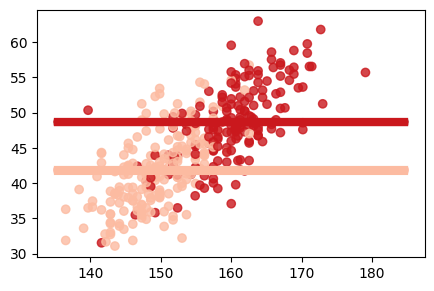

In [17]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(df['height'], df['weight'], c=df['male'], cmap='Reds', alpha=0.8, vmin=-0.5, vmax=1.5)
for i in range(50):
    ax.plot(x, np.repeat(idata.posterior['alpha'].mean(axis=0)[i,0].values, len(x)), color=reds[0])
    ax.plot(x, np.repeat(idata.posterior['alpha'].mean(axis=0)[i,1].values, len(x)), color=reds[1])
ax.set_aspect('equal')

plt.show()

# 2. Sketch out the causal assumptions (DAG) of the model
In this case, I have sketched out the DAG on my notebook.

# 3. Define a generative model
### Generate data
Here, we generate synthetic data based on causal assumptions of our system. Since we want to estimate the direct effect of sex on weight, we simulate data where `bs` are identical and `as` differ for men and women. By doing this, we've removed the effect of height on weight thus leaving only the direct effect of sex on weight.

Now, we'll move on to our second question

#### Direct causal effect of sex on weight

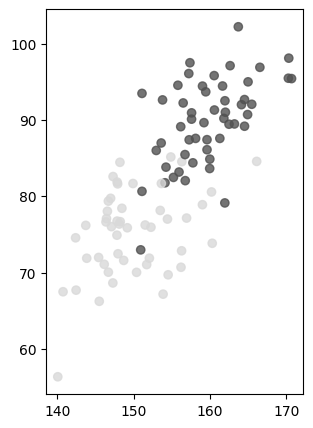

In [18]:
S = np.random.randint(0, 2, size=100)
a = np.array([0, 10])
b = np.array([0.5, 0.5])
sim_data = sim_HW(S, a, b)

fig,ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(sim_data['height'], sim_data['weight'], c=sim_data['male'], cmap='Greys', alpha=0.8, vmin=-0.5, vmax=1.5)
ax.set_aspect('equal')

plt.show()

# 4. Design a statistical way to build the estimator using the generative model
### Fit model to generated data
Here, we fit a linear regression to the generated data. To stratify by height, we centre our data i.e., we create a centred height variable.

In [19]:
sim_data['height_centred'] = sim_data['height'] - sim_data['height'].mean()

In [20]:
with pm.Model() as model:
    # Define priors
    alpha = pm.Normal('alpha', mu=[60, 60], sigma=[10, 10], shape=2)
    beta = pm.Uniform('beta', lower=[0, 0], upper=[1, 1], shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # Define likelihood
    weight_obs = pm.Normal('weight_obs', mu=alpha[sim_data['male'].values] + beta[sim_data['male'].values] * sim_data['height_centred'], sigma=sigma, observed=sim_data['weight'].values)
    
    # Inference
    idata = pm.sample(1000)
    
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],77.303,0.976,75.556,79.218,0.018,0.012,3109.0,2787.0,1.0
alpha[1],86.449,0.955,84.640,88.200,0.018,0.013,2747.0,2449.0,1.0
beta[0],0.412,0.134,0.138,0.641,0.002,0.002,3089.0,2615.0,1.0
beta[1],0.664,0.140,0.428,0.946,0.003,0.002,2810.0,2360.0,1.0
sigma,5.103,0.372,4.397,5.764,0.007,0.005,3235.0,2777.0,1.0


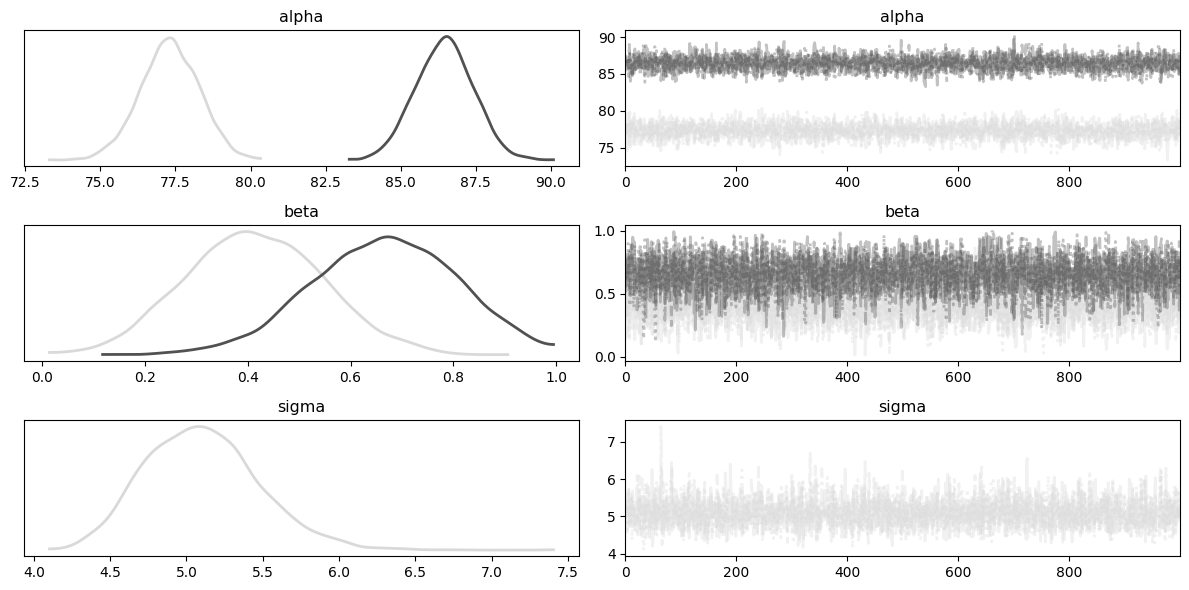

In [21]:
az.plot_trace(idata, compact=True, combined=True, compact_prop={'color': blacks, 'linewidth': [2,2]})
plt.tight_layout()
plt.show()

In [22]:
idata.posterior['weight_mod'] = idata.posterior['alpha'] + idata.posterior['beta'] * (x - sim_data['height'].mean())

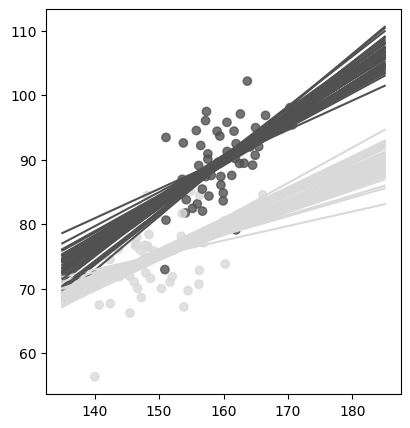

In [23]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(sim_data['height'], sim_data['weight'], c=sim_data['male'], cmap='Greys', alpha=0.8, vmin=-0.5, vmax=1.5)
for i in range(50):
    ax.plot(x, idata.posterior['weight_mod'].mean(axis=0)[i,0,0].values, color=blacks[0])
    ax.plot(x, idata.posterior['weight_mod'].mean(axis=0)[i,1,1].values, color=blacks[1])
ax.set_aspect('equal')

plt.show()

# 5. Analyse real data
Now that we know our model works with the synthetic data, we'll feed the real data from above.

In [24]:
df['height_centred'] = df['height'] - df['height'].mean()

df_sampled = df.sample(n=len(df))

In [25]:
with pm.Model() as model:
    # Define priors
    alpha = pm.Normal('alpha', mu=[60, 60], sigma=[10, 10], shape=2)
    beta = pm.Uniform('beta', lower=[0, 0], upper=[1, 1], shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # Define likelihood
    weight_obs = pm.Normal('weight_obs', mu=alpha[df_sampled['male'].values] + beta[df_sampled['male'].values] * df_sampled['height_centred'], sigma=sigma, observed=df_sampled['weight'].values)
    
    # Inference
    idata = pm.sample(1000)
    
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],45.192,0.435,44.346,45.987,0.008,0.005,3170.0,2802.0,1.0
alpha[1],45.092,0.475,44.214,45.959,0.009,0.006,2953.0,2846.0,1.0
beta[0],0.662,0.060,0.550,0.776,0.001,0.001,3326.0,2854.0,1.0
beta[1],0.612,0.057,0.499,0.711,0.001,0.001,2981.0,2784.0,1.0
sigma,4.269,0.163,3.968,4.565,0.003,0.002,3239.0,2159.0,1.0


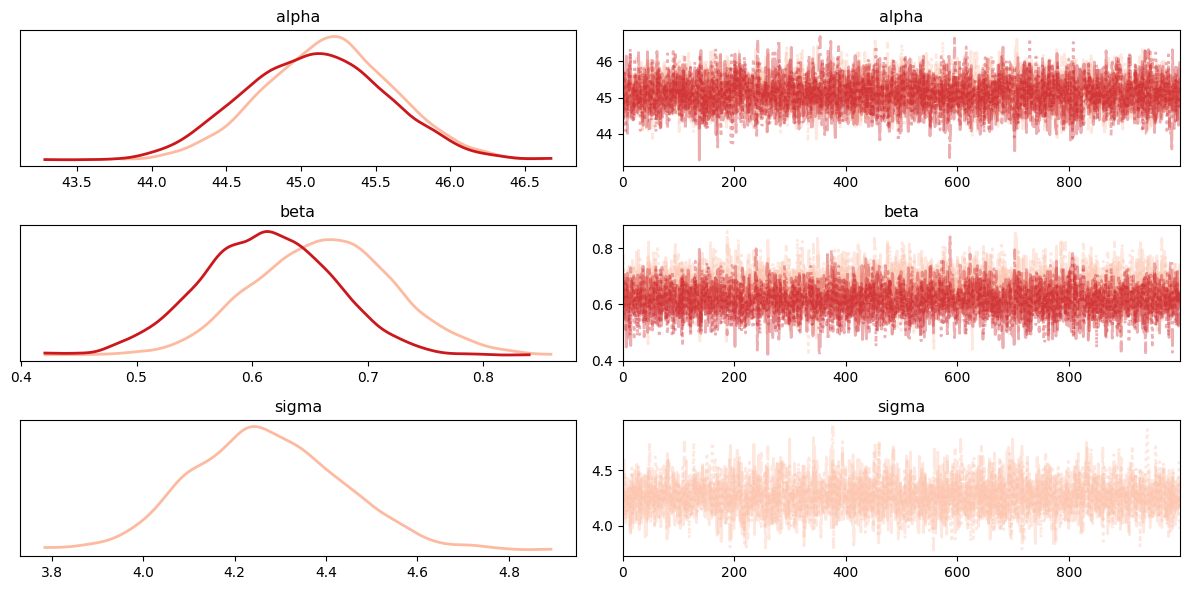

In [26]:
az.plot_trace(idata, compact=True, combined=True, compact_prop={'color': reds, 'linewidth': [2,2]})
plt.tight_layout()
plt.show()

In [27]:
idata.posterior['weight_mod'] = idata.posterior['alpha'] + idata.posterior['beta'] * (x - df['height'].mean())

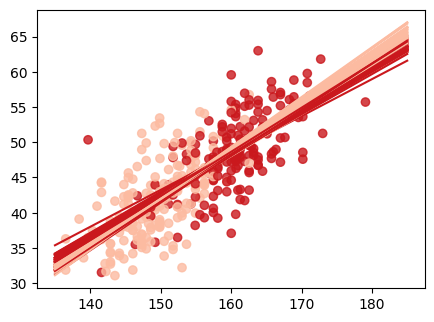

In [28]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(df['height'], df['weight'], c=df['male'], cmap='Reds', alpha=0.8, vmin=-0.5, vmax=1.5)
for i in range(50):
    ax.plot(x, idata.posterior['weight_mod'].mean(axis=0)[i,0,0].values, color=reds[0])
    ax.plot(x, idata.posterior['weight_mod'].mean(axis=0)[i,1,1].values, color=reds[1])
ax.set_aspect('equal')

plt.show()

To investigate the direct effect of sex on height, we use the regression line and simulate distributions of weights for men and women of the same height.

In [29]:
idata.posterior['weight_female'] = idata.posterior['alpha'][...,0] + idata.posterior['beta'][...,0] * (x - df['height'].mean())
idata.posterior['weight_male'] = idata.posterior['alpha'][...,1] + idata.posterior['beta'][...,1] * (x - df['height'].mean())

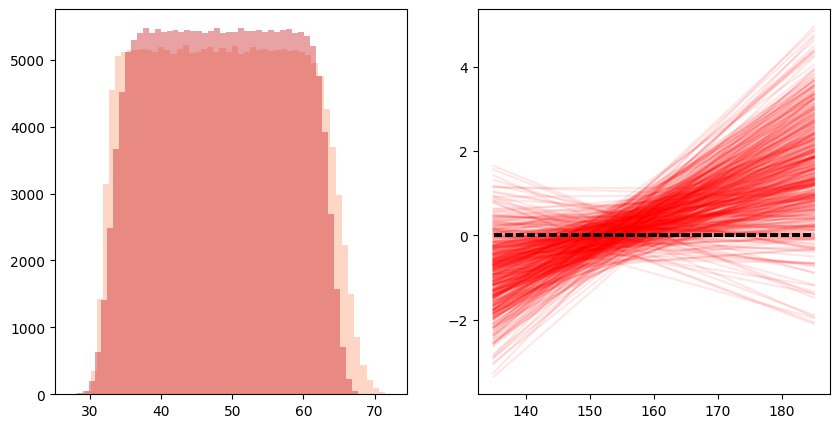

In [47]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist(idata.posterior['weight_female'].values.reshape(-1,), color=reds[0], bins=50, alpha=0.6)
ax1.hist(idata.posterior['weight_male'].values.reshape(-1,), color=reds[1], bins=50, alpha=0.4)

for i in range(500):
    ax2.plot(x, (idata.posterior['weight_female'].values.mean(axis=0) - idata.posterior['weight_male'].values.mean(axis=0))[i], color='red', alpha=0.1)
    ax2.hlines(y=0, xmin=135, xmax=185, color='black', linestyles='dashed')

plt.show()

Here, we have plotted the difference in weight between men and women for specified heights. On average, we see that for shorter heights, men tend to be heavier while women tend to be heavier at taller heights. However, the entire band of lines straddle `y=0`. So we can safely say that there is no direct causal effect of sex on weight. All the effect of sex on weight is indirectly mediated through height.

# Bonus Content
## Full Luxury Bayes
Now we will run model that allows us to estimate both estimands above with the same model.

In [49]:
with pm.Model() as model:
    # Define priors for weight
    alpha = pm.Normal('alpha', mu=[60, 60], sigma=[10, 10], shape=2)
    beta = pm.Uniform('beta', lower=[0, 0], upper=[1, 1], shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # Define priors for height
    nu = pm.Normal('nu', mu=[160, 160], sigma=[10, 10], shape=2)
    tau = pm.Uniform('tau', lower=0, upper=10)
    
    # Define likelihood
    weight_obs = pm.Normal('weight_obs', mu=alpha[df_sampled['male'].values] + beta[df_sampled['male'].values] * df_sampled['height_centred'].values, sigma=sigma, observed=df_sampled['weight'].values)
    height_obs = pm.Normal('height_obs', mu=nu[df_sampled['male'].values], sigma=tau, observed=df_sampled['height'].values)
    
    # Inference
    idata = pm.sample(1000)
    
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],45.194,0.440,44.391,46.046,0.007,0.005,4302.0,2835.0,1.0
alpha[1],45.079,0.473,44.186,45.947,0.007,0.005,4601.0,3206.0,1.0
nu[0],149.536,0.416,148.757,150.319,0.005,0.004,6710.0,2439.0,1.0
nu[1],160.357,0.429,159.578,161.172,0.005,0.004,6359.0,3278.0,1.0
beta[0],0.661,0.061,0.548,0.773,0.001,0.001,4553.0,3187.0,1.0
beta[1],0.611,0.056,0.512,0.725,0.001,0.001,4746.0,2888.0,1.0
sigma,4.266,0.164,3.975,4.579,0.002,0.002,5409.0,3085.0,1.0
tau,5.557,0.207,5.171,5.950,0.003,0.002,5320.0,3001.0,1.0


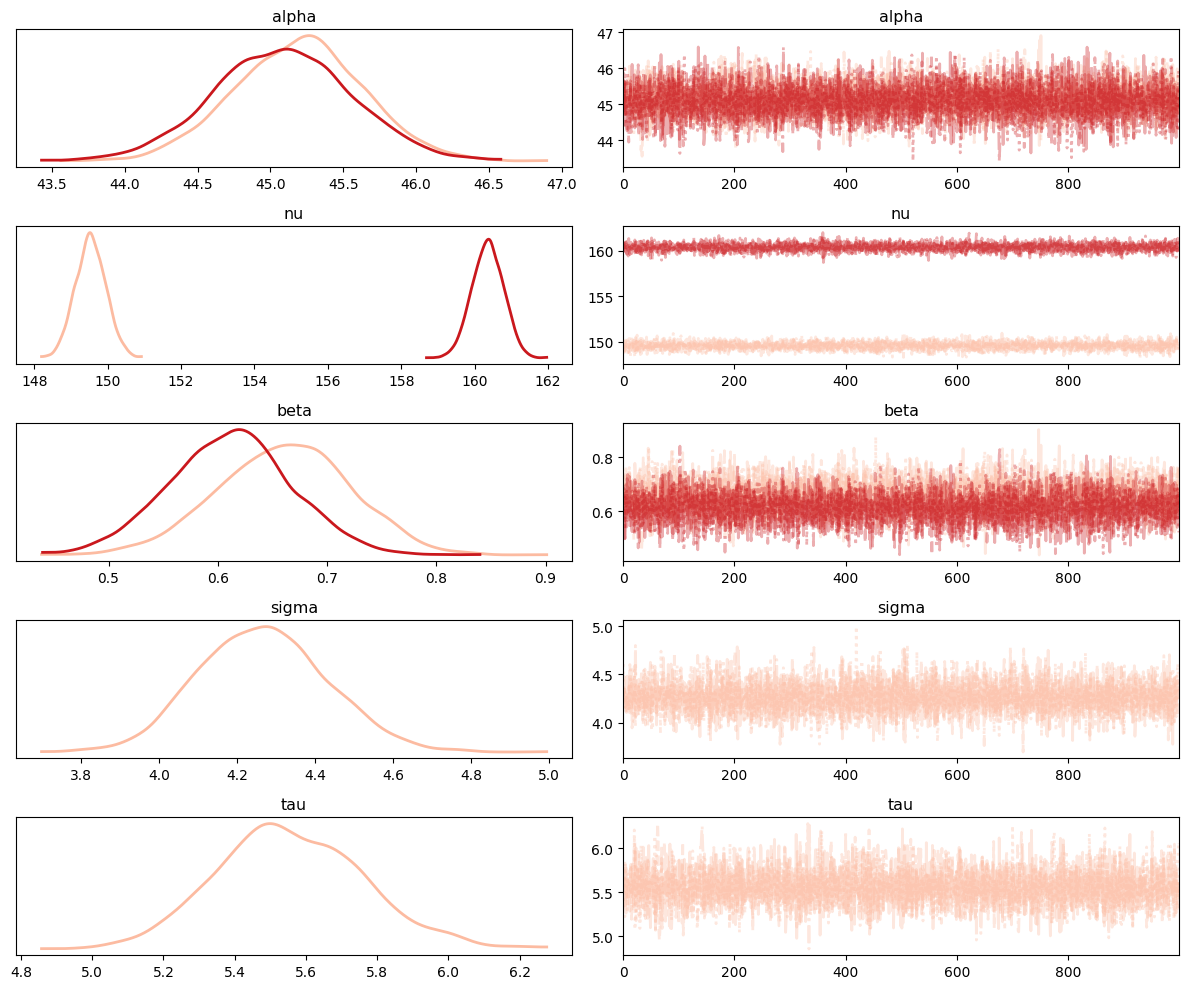

In [50]:
az.plot_trace(idata, compact=True, combined=True, compact_prop={'color': reds, 'linewidth': [2,2]})
plt.tight_layout()
plt.show()

Now, we will use the posteriors from this full luxury bayesian model and run simulations to estimate the estimand.

In [63]:
# Simulate height and weight for women
height_female = rng.normal(idata.posterior['nu'][...,0], idata.posterior['tau'])
weight_female = rng.normal(idata.posterior['alpha'][...,0] + idata.posterior['beta'][...,0] * (height_female - df_sampled['height'].mean()), idata.posterior['sigma'])

# Simulate height and weight for men
height_male = rng.normal(idata.posterior['nu'][...,1], idata.posterior['tau'])
weight_male = rng.normal(idata.posterior['alpha'][...,1] + idata.posterior['beta'][...,1] * (height_male - df_sampled['height'].mean()), idata.posterior['sigma'])

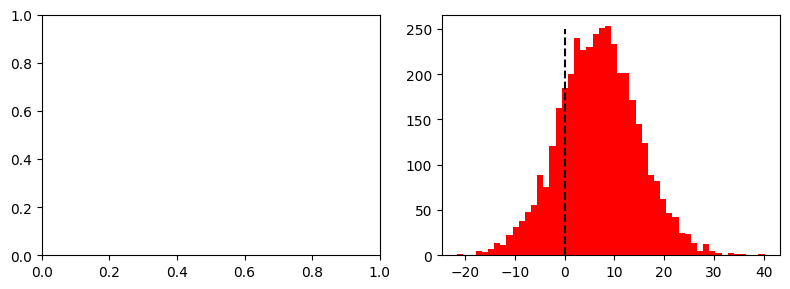

In [71]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(8, 3))

ax2.hist(weight_male.reshape(-1) - weight_female.reshape(-1), color='red', bins=50)
ax2.vlines(x=0, ymin=0, ymax=250, color='black', linestyles='dashed')

plt.tight_layout()
plt.show()

In [72]:
percentileofscore(weight_male.reshape(-1) - weight_female.reshape(-1), 0., kind='rank')

19.0